In [188]:
#import package
import os
import IPython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram, find_peaks

In [189]:
# Our hearing range is commonly 20 Hz to 20 kHz

#label frequency with correspnding note
curr_freq = 55
freq_list = []

# I want to calculate 8 octaves of notes. Each octave has 12 notes. Looping for 96 steps:
for i in range(96): 
    freq_list.append(curr_freq)
    curr_freq *= np.power(2, 1/12) # Multiplying by 2^(1/12)

#reshaping and creating dataframe
freq_array = np.reshape(np.round(freq_list,1), (8, 12))
cols = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]
df_note_freqs = pd.DataFrame(freq_array, columns=cols)
print("NOTE FREQUENCIES IN WESTERN MUSIC")
df_note_freqs.head(10)

NOTE FREQUENCIES IN WESTERN MUSIC


,A,A#,B,C,C#,D,D#,E,F,F#,G,G#
0,55.0,58.3,61.7,65.4,69.3,73.4,77.8,82.4,87.3,92.5,98.0,103.8
1,110.0,116.5,123.5,130.8,138.6,146.8,155.6,164.8,174.6,185.0,196.0,207.7
2,220.0,233.1,246.9,261.6,277.2,293.7,311.1,329.6,349.2,370.0,392.0,415.3
3,440.0,466.2,493.9,523.3,554.4,587.3,622.3,659.3,698.5,740.0,784.0,830.6
4,880.0,932.3,987.8,1046.5,1108.7,1174.7,1244.5,1318.5,1396.9,1480.0,1568.0,1661.2
5,1760.0,1864.7,1975.5,2093.0,2217.5,2349.3,2489.0,2637.0,2793.8,2960.0,3136.0,3322.4
6,3520.0,3729.3,3951.1,4186.0,4434.9,4698.6,4978.0,5274.0,5587.7,5919.9,6271.9,6644.9
7,7040.0,7458.6,7902.1,8372.0,8869.8,9397.3,9956.1,10548.1,11175.3,11839.8,12543.9,13289.8


In [190]:
path_1 = "../input/musical-instrument-chord-classification/Audio_Files/Major/Major_0.wav"
path_2 = "../input/musical-instrument-chord-classification/Audio_Files/Minor/Minor_169.wav"
path_3 = "../input/musical-instrument-chord-classification/Audio_Files/Major/Major_111.wav"
IPython.display.Audio(path_1, rate = 44100) #A C E major

In [191]:
IPython.display.Audio(path_2, rate = 44100) #minor

In [192]:
IPython.display.Audio(path_3, rate = 44100) #major

## 1.4. Detection of Harmonic Frequencies

In [193]:
# I would like to create a method so that I can use in the next section
# The method will read sound file, apply Fourier, find peak frequencies and return
# Input: path of the sound file
# Output: Frequency peaks
# print_peaks = true to plot peaks

def find_harmonics(path, print_peaks=False):
    fs, X = wavfile.read(path)
    N = len(X)
    X_F = fft(X)
    X_F_onesided = 2.0/N * np.abs(X_F[0:N//2])
    freqs = fftfreq(N, 1/fs)[:N//2]
    freqs_50_index = np.abs(freqs - 50).argmin()
    
    h = X_F_onesided.max()*5/100
    peaks, _ = find_peaks(X_F_onesided, distance=10, height = h)
    peaks = peaks[peaks>freqs_50_index]
    harmonics = np.round(freqs[peaks],2)
    
    if print_peaks:
        i = peaks.max() + 100
        plt.plot(freqs[:i], X_F_onesided[:i])
        plt.plot(freqs[peaks], X_F_onesided[peaks], "x")
        plt.xlabel('Frequency [Hz]')
        plt.show()
    return harmonics

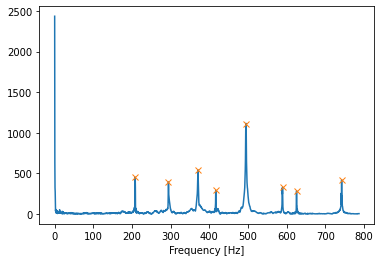

Harmonics: [208. 294. 370. 416. 494. 589. 625. 742.]


In [194]:
# Another example to check if method is working correctly
path = "../input/musical-instrument-chord-classification/Audio_Files/Minor/Minor_169.wav"

harmonics_2 = find_harmonics(path, print_peaks=True)
print("Harmonics: {}".format(np.round(harmonics_2)))

#map the harmonic frequency to the table we build before to determine the chord

# 2. Importing Dataset

In this section, I will create a DataFrame so that I can analyze all the sound data together. There are more than 800 wav files. First, I will loop through all the files and find harmonics. I will save chord type, file name and all harmonics for each file. I will also save minimum & maximum harmonics and the number of harmonics for easier analysis. After the loop, I will convert it to a DataFrame.

In [195]:
path = "/kaggle/input/musical-instrument-chord-classification/Audio_Files"
data = []
max_harm_length = 0 # i will keep track of max harmonic length for naming columns

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        foldername = os.path.basename(dirname)
        full_path = os.path.join(dirname, filename)
        freq_peaks = find_harmonics(full_path)
        
        max_harm_length = max(max_harm_length, len(freq_peaks))
        
        cur_data = [foldername, filename]
        cur_data.extend([freq_peaks.min(), freq_peaks.max(), len(freq_peaks)])
        cur_data.extend(freq_peaks)
        
        data.append(cur_data)

In [196]:
# Column Names for DataFrame:
cols = ["Chord Type", "File Name", "Min Harmonic", "Max Harmonic", "# of Harmonics"]
for i in range(max_harm_length):
    cols.append("Harmonic {}".format(i+1))

# Creating DataFrame
df = pd.DataFrame(data, columns=cols)
df.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Harmonic 29,Harmonic 30,Harmonic 31,Harmonic 32,Harmonic 33,Harmonic 34,Harmonic 35,Harmonic 36,Harmonic 37,Harmonic 38
0,Major,Major_337.wav,83.04,993.49,18,83.04,130.87,165.22,196.52,247.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Major,Major_19.wav,278.18,1052.73,8,278.18,350.45,467.27,556.36,624.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Major,Major_444.wav,104.35,1873.93,27,104.35,155.22,209.13,262.18,311.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Major,Major_380.wav,138.67,2449.33,28,138.67,155.56,208.44,262.22,277.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Major,Major_368.wav,138.67,2492.44,27,138.67,208.89,247.11,277.78,349.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3. Data Exploration

In [197]:
df["Chord Type"].value_counts()

Major    502
Minor    357
Name: Chord Type, dtype: int64

## 3.1. Min and Max Harmonics

## 3.2. Number of Harmonics

In the column "# of Harmonics", I have information that how many harmonic values are not null in that row. For example if "# of Harmonics" is 12, that row will have values from "Harmonic 1" to "Harmonic 12", but after "Harmonic 13" we will see NaN values. This "# of Harmonics" column will not be directly related to my classification model but will make it easier to analyze other columns.

Using describe method on "# of harmonics", I see that
* min is 8 --> every row at least 8 harmonics value
* max is 38 --> last column will be "Harmonic 38"
* starting with column "Harmonic 9", there will be NaN values
* since harmonics are ordered, missing values will increase with each column
* the mean value for the number of harmonics is 20

Looking at the number of missing values, I know that I will drop most of the columns. Harmonics bigger than 20 are gone. The first 8 harmonics are absolutely important. But I am not sure about the harmonics in between. I have to make more exploration to decide for them.

In [198]:
df["# of Harmonics"].describe()

count    859.000000
mean      20.389988
std        6.656608
min        8.000000
25%       15.000000
50%       20.000000
75%       25.000000
max       38.000000
Name: # of Harmonics, dtype: float64

In [199]:
print("Number of Missing values:")
miss_values = df.isnull().sum().sort_values(ascending=False)
miss_values[miss_values>0]

Number of Missing values:


Harmonic 38    858
Harmonic 37    857
Harmonic 36    855
Harmonic 35    847
Harmonic 34    839
Harmonic 33    829
Harmonic 32    813
Harmonic 31    793
Harmonic 30    773
Harmonic 29    754
Harmonic 28    720
Harmonic 27    682
Harmonic 26    656
Harmonic 25    611
Harmonic 24    551
Harmonic 23    501
Harmonic 22    471
Harmonic 21    438
Harmonic 20    406
Harmonic 19    382
Harmonic 18    345
Harmonic 17    306
Harmonic 16    241
Harmonic 15    191
Harmonic 14    150
Harmonic 13    108
Harmonic 12     74
Harmonic 11     46
Harmonic 10     20
Harmonic 9      10
dtype: int64

## 3.3. Feature Engineering on Harmonics

Let's start exploring harmonics. "Harmonic 1" is the same column as "Min Harmonic" since harmonics are ordered. So I will start with "Harmonic 2". When I plotted the distribution of Harmonic 2 with hue Chord Type, I can't see a direct relationship between Harmonic 2 and Chord. But I have an idea. I already know that difference between Major and Minor comes from the intervals. And the frequency of notes increases on a logarithmic scale. If I divide Harmonic 2 by Harmonic 1, I can obtain the first interval.

In [200]:
df_original = df.copy() # Keeping original of df, I may need later

In [201]:
df["Interval 1"] = df["Harmonic 2"].div(df["Harmonic 1"], axis=0)

I'm really happy with the distribution of Interval 1. At last, we have data that changes with Chord Type. I will continue to calculate intervals using a loop. There are 38 harmonics but we already know that there are a huge amount of missing values for higher harmonics. So, I will loop for the first 20 intervals. For each interval, I will calculate the ratio of the current harmonic to the previous one.

In [202]:
df = df_original.copy() # refreshing df

for i in range(1,21):
    curr_interval = "Interval {}".format(i)
    curr_harm = "Harmonic {}".format(i+1)
    prev_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df[prev_harm], axis=0)
    
df.head()
df['File Name'].to_csv('link.csv')

Looking at the huge plot of intervals:
* The first 4 interval looks interesting and I will use them in my model.
* After interval 13, the variable loses its importance completely.
* Starting from interval 8, there are missing values. I will most probably drop these intervals.
* Interval 5, 6 and 7 have no missing values, I will decide for them later.

So far, we have analyzed the interval between the consecutive harmonics. What about total interval until specific harmonic? I mean the interval between the specific harmonic and the first harmonic. I will plot them using a loop again.

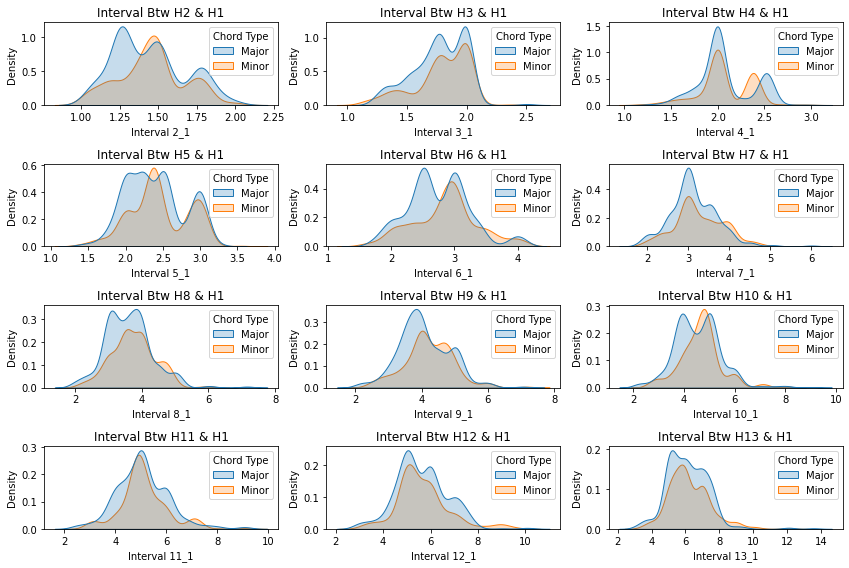

In [203]:
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
for i in range(2,14):
    curr_interval = "Interval {}_1".format(i)
    curr_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df["Harmonic 1"], axis=0)
    
    plt.subplot(4, 3, i-1)
    plt.gca().set_title("Interval Btw H{} & H1".format(i))
    sns.kdeplot(data=df, x=curr_interval, hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

# 4. Model Building

In [204]:
# importing packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## 4.1. Preprocessing Data

There is just one step left before training the classification model. Since the Chord Type column is categorical and consists of strings, I will replace "Major" with 1 and "Minor" with 0. Finally, select columns that I will use in training and split the data into training and validation sets. I used test size as %40.

In [205]:
df["Chord Type"] = df["Chord Type"].replace("Major", 1)
df["Chord Type"] = df["Chord Type"].replace("Minor", 0)

columns = ["Interval 1", "Interval 2", "Interval 3", "Interval 4"]
columns.extend(["Interval 4_1", "Interval 5_1", "Interval 6_1"])
train_X, val_X, train_y, val_y = train_test_split(df[columns], df["Chord Type"], test_size=0.40, random_state=0)

train_X.head()

#output validation
val_X.to_csv('val_X.csv')

## 4.2. Model Selection

In order to select a classification model, I will try 6 different models in this section and compare their cross validation score.

In [206]:
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier(random_state=0)
rfc = RandomForestClassifier(random_state=0)

score_knn = cross_val_score(knn, train_X, train_y, cv=10).mean()
score_dtc = cross_val_score(dtc, train_X, train_y, cv=10).mean()
score_rfc = cross_val_score(rfc, train_X, train_y, cv=10).mean()

In [207]:
print("Cross Val Score for KNeighbors Classifier: {:.2f}".format(score_knn))
print("Cross Val Score for Decision Tree Classifier: {:.2f}".format(score_dtc))
print("Cross Val Score for Random Forest Classifier: {:.2f}".format(score_rfc))

Cross Val Score for KNeighbors Classifier: 0.83
Cross Val Score for Decision Tree Classifier: 0.90
Cross Val Score for Random Forest Classifier: 0.92


## 4.3. Model Training and Prediction

In the previous section, I tried 6 different models and Random Forest Classifier works really well with my dataset. I obtained 0.92 success rate with this model. After Random Forest Classifier, Decision Tree Classifier obtained %90 and KNeighbors Classifier obtained %83 success rate. 

Now, I will continue with Random Forest Classifier. First, I will train my model with the training dataset and then make a prediction on the validation dataset to see the accuracy.

In [208]:
# defining my classifier RF
rf_classifier = RandomForestClassifier(random_state=0)
rf_classifier.fit(train_X, train_y) # training classifier
rf_pred_y = rf_classifier.predict(val_X) # making prediction on validation

In [209]:
# defining my classifier KN
kn_classifier = KNeighborsClassifier(n_neighbors=3)
kn_classifier.fit(train_X, train_y) # training classifier
kn_pred_y = kn_classifier.predict(val_X) # making prediction on validation

In [210]:
'RF accuracy'
rf_cm = confusion_matrix(val_y, rf_pred_y)
rf_acc = accuracy_score(val_y, rf_pred_y)

print("Confusion Matrix:")
print(rf_cm)
print("Accuracy Score: {:.2f}".format(rf_acc))

Confusion Matrix:
[[121  12]
 [ 10 201]]
Accuracy Score: 0.94


In [211]:
'KN accuracy'
kn_cm = confusion_matrix(val_y, kn_pred_y)
kn_acc = accuracy_score(val_y, kn_pred_y)

print("Confusion Matrix:")
print(kn_cm)
print("Accuracy Score: {:.2f}".format(kn_acc))

Confusion Matrix:
[[103  30]
 [ 34 177]]
Accuracy Score: 0.81


In [212]:
'DT accuracy'
dt_classifier = DecisionTreeClassifier(random_state=0)
dt_classifier.fit(train_X, train_y) # training classifier
dt_pred_y = dt_classifier.predict(val_X) # making prediction on validation

In [213]:
'KN accuracy'
dt_cm = confusion_matrix(val_y, dt_pred_y)
dt_acc = accuracy_score(val_y, dt_pred_y)

print("Confusion Matrix:")
print(dt_cm)
print("Accuracy Score: {:.2f}".format(dt_acc))

Confusion Matrix:
[[117  16]
 [ 12 199]]
Accuracy Score: 0.92


In [214]:
acc = 0
count = 0
for a,b,c,d in zip(dt_pred_y,kn_pred_y,rf_pred_y, val_y):
    count+=1
    if np.sum([a,b,c]) >= 2: 
        p = 1
        #print(p, d)
        if p == d:
            acc+=1
    else: 
        p = 0
        #print(p, d)
        if p==d:
            acc+=1
print(acc/count)

0.9273255813953488


In [215]:
import joblib
# save RF
joblib.dump(rf_classifier, "./random_forest.joblib")
# save DT
joblib.dump(dt_classifier, "./decision_tree.joblib")
# save KN
joblib.dump(kn_classifier, "./k_neighbours.joblib")

['./k_neighbours.joblib']

In [216]:
'example how to load pre-trained models'

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import joblib
dt_classifier = DecisionTreeClassifier(random_state=0)
kn_classifier = KNeighborsClassifier(n_neighbors=3)
rf_classifier = RandomForestClassifier(random_state=0)

rf_classifier = joblib.load('/kaggle/working/random_forest.joblib')
kn_classifier = joblib.load('/kaggle/working/k_neighbours.joblib')
dt_classifier = joblib.load('/kaggle/working/decision_tree.joblib')

In [257]:
#from link.csv file to know which major as the input of the model
val_X_df = pd.read_csv('val_X.csv')
list_df = pd.read_csv('link.csv')


val_X_df.set_axis(['id', 'Interval 1', 'Interval 2','Interval 3', 'Interval 4', 'Interval 4_1', 'Interval 5_1', 'Interval 6_1'], axis='columns', inplace=True)
print(val_X_df)

list_df.set_axis(['id', 'File Name'], axis='columns', inplace=True)
print(list_df)

#check for the first row of the validationX:
print(val_X_df.id)

wav_file_name = '0'
for i in range(len(list_df)):
    if val_X_df.id[0] == list_df.id[i]:
        wav_file_name = list_df['File Name'][i]
        break

chord_type = wav_file_name[0:5]
IPython.display.Audio('../input/musical-instrument-chord-classification/Audio_Files/' + chord_type + '/' + list_df['File Name'][i], rate = 44100)

      id  Interval 1  Interval 2  Interval 3  Interval 4  Interval 4_1  \
0    145    1.413077    1.094765    1.023951    1.035976      1.584038   
1    204    1.490757    1.341673    1.259337    1.185534      2.518809   
2    271    1.057746    1.261215    1.191642    1.256813      1.589703   
3    258    1.504500    1.332336    1.124694    1.120985      2.254449   
4    530    1.194108    1.187226    1.412476    1.193872      2.002432   
..   ...         ...         ...         ...         ...           ...   
339  761    1.417016    1.259964    1.122449    1.191909      2.004008   
340   15    1.586092    1.259075    1.192117    1.331220      2.380668   
341  245    1.585979    1.056982    1.064356    1.119275      1.784234   
342  372    1.792424    1.122683    1.235065    1.021706      2.485349   
343    6    1.585979    1.056982    1.064356    1.119275      1.784234   

     Interval 5_1  Interval 6_1  
0        1.641026      1.994295  
1        2.986135      3.934759  
2        